In [1]:
import numpy as np
import torch
import keras 
import pylab as pl
from torcheval.metrics.functional import multiclass_accuracy
from numpy.random import choice

In [2]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28))
train_images = train_images.astype('float32')/255
test_images = test_images.reshape((10000, 28, 28))
test_images = test_images.astype('float32')/255

In [4]:
class Net(torch.nn.Module):          
    def __init__(self):     
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same')
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same')
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same')
        self.flat = torch.nn.Flatten()
        self.mlp = torch.nn.Linear(in_features=int(128*(28/4)**2), out_features=10, )
    
    def forward(self,inp):
        x = self.conv1(inp)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.mlp(x)
        return (x)
    
    def training_GD(self, Loss, X_train, y_train, n_epochs, alpha, verbose=False):
        Accuracies = []
        Losses = []
        if verbose:
            print('Model initialisation\nLaunching GD training of model \n Number of parameters : {}'.format(sum(p.numel() for p in self.parameters())))
        for T in range(n_epochs):
            hat_y = self.forward(X_train) # Forward pass: Compute predicted y by passing  x to the model
            loss = Loss(hat_y, y_train) # Forward pass : Compute the loss
            self.zero_grad() # re-init the gradients (otherwise they are cumulated)
            loss.backward() # Backpropagation
            with torch.no_grad():
                for param in self.parameters() : # Parameters' update
                    param -= alpha * param.grad
            acc = multiclass_accuracy(hat_y,y_train)
            Accuracies.append(acc)
            Losses.append(loss)
            if verbose:
                print('Epoch {} / {} : Loss = {}'.format(T+1, n_epochs, loss))
        return Losses, Accuracies
    
    def training_SGD(self, Loss, X_train, y_train, n_epochs, batch_size, alpha, verbose=False):
        Accuracies = []
        Losses = []
        if verbose:
            print('Model initialisation\nLaunching SGD training of model \n Number of parameters : {}'.format(sum(p.numel() for p in self.parameters())))
        for T in range(n_epochs):
            batch_indexes = choice(range(y_train.shape[0]), size=batch_size, replace=False)
            Xb, yb = X_train[batch_indexes], y_train[batch_indexes]
            hat_yb = self.forward(Xb) # Forward pass: Compute predicted y by passing  x to the model
            loss = Loss(hat_yb, yb) # Forward pass : Compute the loss
            self.zero_grad() # re-init the gradients (otherwise they are cumulated)
            loss.backward() # Backpropagation
            with torch.no_grad():
                for param in self.parameters() : # Parameters' update
                    param -= alpha * param.grad
                hat_y = self.forward(X_train)
                acc = multiclass_accuracy(hat_y, y_train)
                loss = Loss(hat_y, y_train)
            Accuracies.append(acc)
            Losses.append(loss)
            if verbose:
                print('Epoch {} / {} : Loss = {}'.format(T+1, n_epochs, loss))
        return Losses, Accuracies
    
    def training_Mom(self, Loss, X_train, y_train, n_epochs, batch_size, alpha, beta, verbose=False):
        Accuracies = []
        Losses = []
        if verbose:
            print('Model initialisation\nLaunching Momentum training of model \n Number of parameters : {}'.format(sum(p.numel() for p in self.parameters())))
        Momentums = [torch.zeros(param.shape) for param in self.parameters()]
        for T in range(n_epochs):
            batch_indexes = choice(range(y_train.shape[0]), size=batch_size, replace=False)
            Xb, yb = X_train[batch_indexes], y_train[batch_indexes]
            hat_yb = self.forward(Xb) # Forward pass: Compute predicted y by passing  x to the model
            loss = Loss(hat_yb, yb) # Forward pass : Compute the loss
            self.zero_grad() # re-init the gradients (otherwise they are cumulated)
            loss.backward() # Backpropagation
            with torch.no_grad():
                for i, param in enumerate(self.parameters()) : # Parameters' update
                    Momentums[i] = beta * Momentums[i] + (1-beta) * param.grad
                    param -= alpha * Momentums[i]
                hat_y = self.forward(X_train)
                acc = multiclass_accuracy(hat_y, y_train)
                loss = Loss(hat_y, y_train)
            Accuracies.append(acc)
            Losses.append(loss)
            if verbose:
                print('Epoch {} / {} : Loss = {}'.format(T+1, n_epochs, loss))
        return Losses, Accuracies
    
    def training_NAG(self, Loss, X_train, y_train, n_epochs, batch_size, alpha, beta, verbose=False):
        # MymodelGrad = Net() # New model to compute gradients on different points
        #with torch.no_grad():
        #    for i, param in enumerate(MymodelGrad.parameters()):
        #        param = list(self.parameters())[i] # Start with same initial parameters
        Accuracies = []
        Losses = []
        if verbose:
            print('Model initialisation\nLaunching NAG training of model \n Number of parameters : {}'.format(sum(p.numel() for p in self.parameters())))
        Momentums = [torch.zeros(param.shape) for param in self.parameters()]
        for T in range(n_epochs):
            self.zero_grad() # re-init the gradients (otherwise they are cumulated)
            batch_indexes = choice(range(y_train.shape[0]), size=batch_size, replace=False)
            Xb, yb = X_train[batch_indexes], y_train[batch_indexes]
            with torch.no_grad():
                for i, param in enumerate(self.parameters()):
                    param -= alpha*beta*Momentums[i]
            hat_yb = self.forward(Xb) # Forward pass: Compute predicted y by passing  x to the model
            loss = Loss(hat_yb, yb) # Forward pass : Compute the loss
            loss.backward() # Backpropagation
            with torch.no_grad():
                for i, param in enumerate(self.parameters()) : # Parameters' update
                    Momentums[i] = beta * Momentums[i] + (1-beta) * param.grad  # Update momentum with gradient of MymodelGrad
                    param -= alpha*(1-beta)*param.grad # Modify parameters of MymodelGrad for next gradient computation
                hat_y = self.forward(X)
                acc = multiclass_accuracy(hat_y, y_train)
                loss = Loss(hat_y, y_train)
            Accuracies.append(acc)
            Losses.append(loss)
            if verbose:
                print('Epoch {} / {} : Loss = {}'.format(T+1, n_epochs, loss))
        return Losses, Accuracies
    


In [5]:
model_ConvNN = Net()

In [10]:
# Some definitions
categorical_cross_entropy = torch.nn.CrossEntropyLoss()
#small_train_images = train_images[:1000,:,:]
#small_train_labels = train_labels[:1000].to(torch.int64)
X = torch.from_numpy(train_images[:1000,]).float().view(1000,1,28,28)
y = torch.from_numpy(train_labels[:1000,]).float().to(torch.int64)
nb_epochs = 150
batch_size = 100
alpha = 0.1
beta = 0.9

In [ ]:
model_ConvNN = Net()
L_gd, A_gd = model_ConvNN.training_GD(categorical_cross_entropy, X, y, nb_epochs, alpha, verbose=True)

In [ ]:
model_ConvNN = Net()
L_sgd, A_sgd = model_ConvNN.training_SGD(categorical_cross_entropy, X, y, nb_epochs, batch_size,alpha, verbose=True)

In [ ]:
model_ConvNN = Net()
L_mom, A_mom = model_ConvNN.training_Mom(categorical_cross_entropy, X, y, nb_epochs, batch_size,alpha, beta, verbose=True)

In [ ]:
model_ConvNN = Net()
L_nag, A_nag = model_ConvNN.training_NAG(categorical_cross_entropy, X, y, nb_epochs, batch_size,alpha, beta, verbose=True)

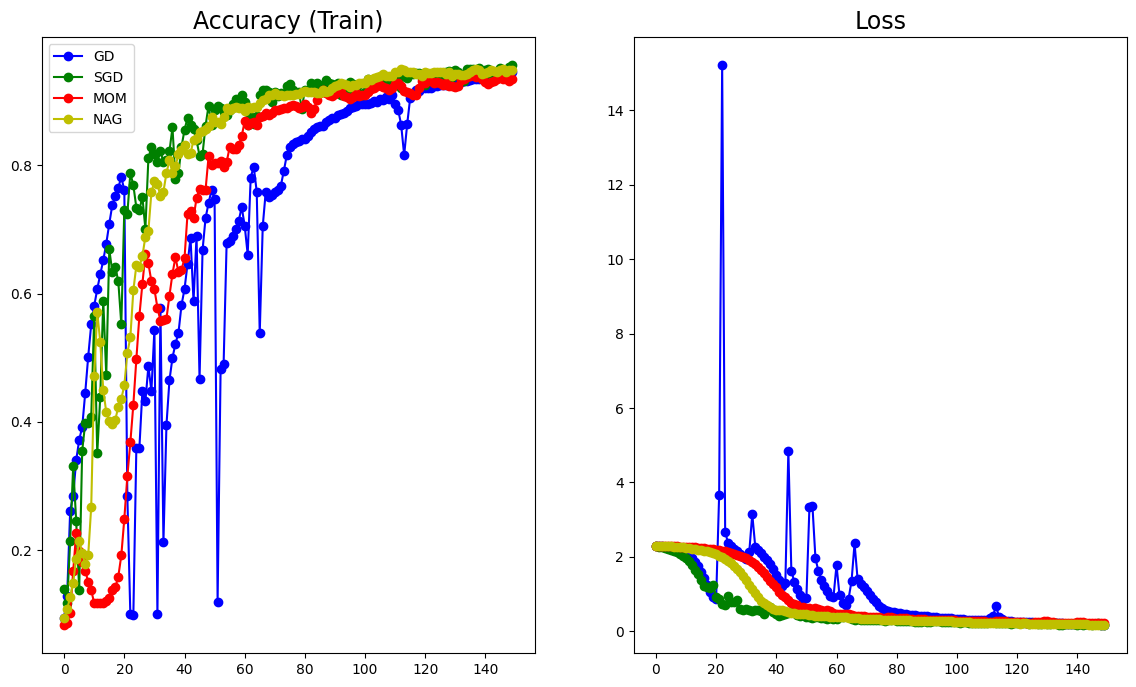

In [15]:
fig, ax = pl.subplots(1,2, figsize=(14,8))

ax[0].plot(A_gd, 'bo-', label='GD')
ax[0].plot(A_sgd, 'go-', label='SGD')
ax[0].plot(A_mom, 'ro-', label='MOM')
ax[0].plot(A_nag, 'yo-', label='NAG')
ax[0].set_title("Accuracy (Train)", size=17)
ax[0].legend()

ax[1].plot([v.detach().numpy() for v in L_gd], 'bo-', label='GD')
ax[1].plot(L_sgd, 'go-', label='SGD')
ax[1].plot(L_mom, 'ro-', label='SGD')
ax[1].plot(L_nag, 'yo-', label='SGD')
ax[1].set_title("Loss", size=17)
ax[0].legend()

In [17]:
Xt = torch.from_numpy(test_images[:1000,]).float().view(1000,1,28,28)
yt = torch.from_numpy(test_labels[:1000,]).float().to(torch.int64)

output_test = model_ConvNN(Xt)
multiclass_accuracy(output_test, yt)

tensor(0.8830)